In [1]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


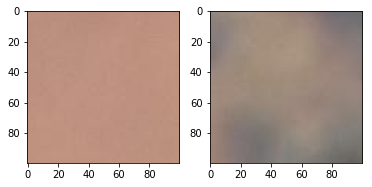

In [2]:
tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.int)
X_val = X_val.astype(np.int)
y_train = y_train.astype(np.int)
y_val = y_val.astype(np.int)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

In [3]:
def train_data(model, loss, val_loss):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format('model_name'))
    hist = model.fit(X_train, y_train,
                     batch_size=64,
                     epochs=50,  # Run thru all the data point in each epoch
                     verbose=1,
                     validation_data=(X_val, y_val),
                     #callbacks=[tensorboard])
                     callbacks=[early_stop, tensorboard])
    #val_err.append(hist.history['val_mean_absolute_error'][-1]) # a dict
    loss.append(hist.history['loss'][-1])
    val_loss.append(hist.history['val_loss'][-1])
    
    
    return loss, val_loss, hist

In [4]:
train_r = True
w_r = tf.Variable(tf.random_uniform([1]),dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(tf.random_uniform([1]),dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(tf.random_uniform([1]),dtype=np.float32,trainable=train_b)
w_colors = [w_r, w_g, w_b]

In [ ]:
train_color = True
color_weights = tf.Variable(tf.random_normal([3,1]),dtype=np.float32,trainable=train_color)

In [10]:
def new_color(X, color_weights):
    new = []
    for image in X:
        r1 = image[:,:,0]
        g1 = image[:,:,1]
        b1 = image[:,:,2]
        #rgb = np.array([r1,g1,b1])
        new_color = r1 * color_weights[0] + g1 * color_weights[1] + b1 * color_weights[2]
        #new_color = np.array([r1, g1, b1]) * color_weights
        new.append(new_color)
    return np.array(new)

X_train1 = new_color(X_train, w_colors)
X_val1 = new_color(X_val, w_colors)

In [11]:
np.shape(X_train1)

(7268,)

In [ ]:
X_train[0] * w_colors

In [7]:
def new_color(X, color_weights):
    new = []
    for image in X:
        r1 = image[:,:,0]
        g1 = image[:,:,1]
        b1 = image[:,:,2]
        #rgb = np.array([r1,g1,b1])
        new_color = r1 * color_weights[0] + g1 * color_weights[1] + b1 * color_weights[2]
        #new_color = np.array([r1, g1, b1]) * color_weights
        new.append(new_color)
    return np.array(new)

X_train2 = new_color(X_train, w_colors)
X_val2 = new_color(X_val, w_colors)

ValueError: operands could not be broadcast together with shapes (3,100,100) (3,) 

In [10]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated